In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt



In [48]:
import pandas as pd

df = pd.read_csv('USD_PLN Historical Data.csv', usecols=['Date', 'Price', 'Open', 'High', 'Low'])


In [49]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# wybór kolumny z danymi, które będą używane do predykcji
target_col = 'Price'

# skalowanie danych do zakresu 0-1
scaler = MinMaxScaler()
df[target_col] = scaler.fit_transform(df[target_col].values.reshape(-1, 1))

# podział danych na zbiór treningowy i testowy
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

# funkcja pomocnicza do tworzenia sekwencji czasowych
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# tworzenie sekwencji czasowych
time_steps = 10

X_train, y_train = create_sequences(train_df[['Price', 'Open', 'High', 'Low']], train_df[target_col], time_steps)
X_test, y_test = create_sequences(test_df[['Price', 'Open', 'High', 'Low']], test_df[target_col], time_steps)

print(f'Treningowe dane wejściowe i wyjściowe: {X_train.shape}, {y_train.shape}')
print(f'Testowe dane wejściowe i wyjściowe: {X_test.shape}, {y_test.shape}')


Treningowe dane wejściowe i wyjściowe: (962, 10, 4), (962,)
Testowe dane wejściowe i wyjściowe: (234, 10, 4), (234,)


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

model.compile(loss='mse', optimizer='adam', run_eagerly=True)
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               68096     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 94,977
Trainable params: 94,977
Non-trai

In [51]:
history = model.fit(
    X_train, y_train,
    epochs=110,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)


Epoch 1/110
28/28 [==============================] - 2s 71ms/step - loss: 0.0247 - val_loss: 0.0128
Epoch 2/110
28/28 [==============================] - 2s 67ms/step - loss: 0.0277 - val_loss: 0.0323
Epoch 3/110
28/28 [==============================] - 2s 69ms/step - loss: 0.0756 - val_loss: 0.0556
Epoch 4/110
28/28 [==============================] - 2s 67ms/step - loss: 0.1158 - val_loss: 0.0408
Epoch 5/110
28/28 [==============================] - 2s 68ms/step - loss: 0.1147 - val_loss: 0.0198
Epoch 6/110
28/28 [==============================] - 2s 67ms/step - loss: 0.0947 - val_loss: 0.0124
Epoch 7/110
28/28 [==============================] - 2s 71ms/step - loss: 0.0860 - val_loss: 0.0119
Epoch 8/110
28/28 [==============================] - 2s 65ms/step - loss: 0.0762 - val_loss: 0.0135
Epoch 9/110
28/28 [==============================] - 2s 65ms/step - loss: 0.0704 - val_loss: 0.0137
Epoch 10/110
28/28 [==============================] - 2s 68ms/step - loss: 0.0674 - val_loss: 0.0135

8/8 [==============================] - 0s 19ms/step


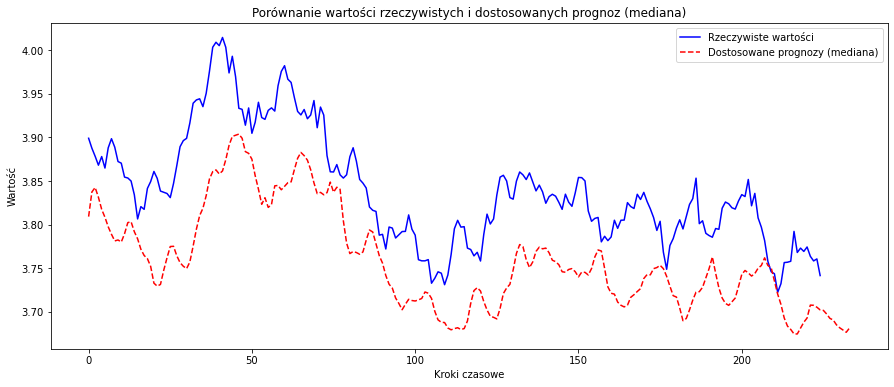

In [52]:
# 1. Dokonaj prognozy na zbiorze testowym
y_pred = model.predict(X_test)

# 2. Oblicz różnicę między prognozami a wartościami rzeczywistymi
differences = y_pred - y_test.reshape(-1, 1)

# Oblicz medianę różnic między prognozami a wartościami rzeczywistymi
median_difference = np.median(differences)

# Dostosuj prognozy, dodając medianę różnic
adjusted_predictions_median = y_pred + median_difference

# Odwróć skalowanie, aby uzyskać prognozy w oryginalnej skali
adjusted_predictions_median_inv = scaler.inverse_transform(adjusted_predictions_median)

# Rysowanie wartości rzeczywistych i dostosowanych prognoz
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Rzeczywiste wartości', color='blue')
plt.plot(adjusted_predictions_median_inv, label='Dostosowane prognozy (mediana)', color='red', linestyle='dashed')
plt.title('Porównanie wartości rzeczywistych i dostosowanych prognoz (mediana)')
plt.xlabel('Kroki czasowe')
plt.ylabel('Wartość')
plt.legend()
plt.show()

In [53]:
model.save('model.h5')


In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Przewidywanie wartości na zbiorze testowym
y_pred = model.predict(X_test)

# Odwrócenie skalowania dla prawdziwych i przewidywanych wartości
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Obliczanie metryk
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"MSE (Mean Squared Error): {mse}")
print(f"RMSE (Root Mean Squared Error): {rmse}")
print(f"MAE (Mean Absolute Error): {mae}")


8/8 [==============================] - 0s 20ms/step
MSE (Mean Squared Error): 0.0019471877027044638
RMSE (Root Mean Squared Error): 0.044126949845921415
MAE (Mean Absolute Error): 0.04057744216103841


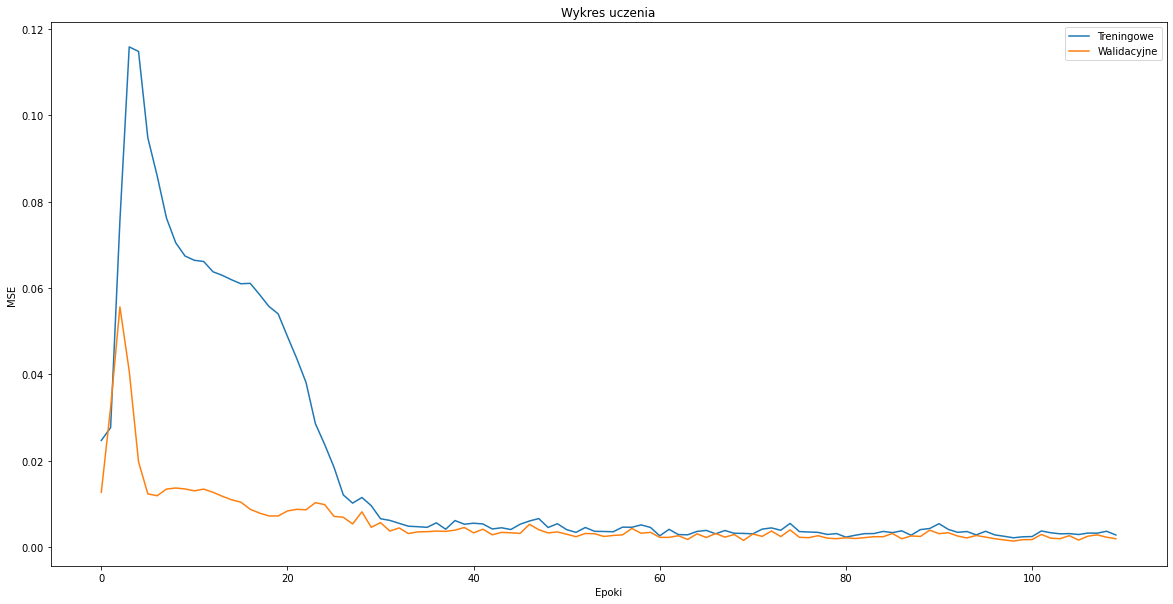

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.plot(history.history['loss'], label='Treningowe')
plt.plot(history.history['val_loss'], label='Walidacyjne')
plt.title('Wykres uczenia')
plt.xlabel('Epoki')
plt.ylabel('MSE')
plt.legend()
plt.show()


8/8 [==============================] - 0s 21ms/step


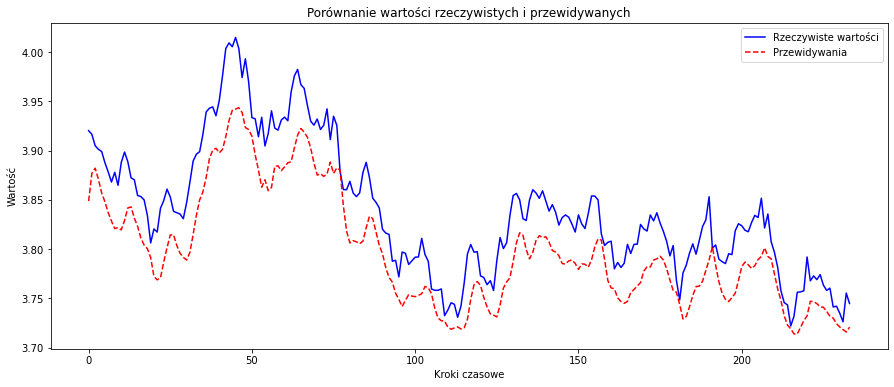

In [56]:
import matplotlib.pyplot as plt

# Przewidywanie wartości na zbiorze testowym
y_pred = model.predict(X_test)

# Odwrócenie skalowania dla prawdziwych i przewidywanych wartości
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Rysowanie wartości rzeczywistych i przewidywanych
plt.figure(figsize=(15, 6))
plt.plot(y_test_inv, label='Rzeczywiste wartości', color='blue')
plt.plot(y_pred_inv, label='Przewidywania', color='red', linestyle='dashed')
plt.title('Porównanie wartości rzeczywistych i przewidywanych')
plt.xlabel('Kroki czasowe')
plt.ylabel('Wartość')
plt.legend()
plt.show()


In [57]:
df2 = pd.read_csv('USD_PLN Historical Data.csv', usecols=['Date', 'Price', 'Open', 'High', 'Low'])

In [58]:
from keras.models import load_model

model = load_model('model.h5')


In [59]:
import datetime
import pandas as pd

# Konwertowanie kolumny 'Date' na obiekt datetime
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values(by='Date', ascending=False)

# Tworzenie sekwencji czasowych
time_stepsp = 10
X, y = create_sequences(df2[['Price', 'Open', 'High', 'Low']], df2['Price'], time_steps)
print("Ostatnie 30 dni, na których opieramy predykcję:\n", df2[['Date', 'Price', 'Open', 'High', 'Low']].head(time_stepsp))

# Skalowanie danych
scaler = MinMaxScaler()
df2['Price'] = scaler.fit_transform(df2['Price'].values.reshape(-1, 1))

# Tworzenie sekwencji czasowych
time_steps = 10
X, y = create_sequences(df2[['Price', 'Open', 'High', 'Low']], df2['Price'], time_steps)

# Wczytanie modelu
model = load_model('model.h5')

# Przewidywanie cen na kolejne 7 dni
predictions = []
current_sequence = X[-1]
for i in range(7):
    current_sequence = current_sequence.reshape(1, time_steps, 4)
    next_prediction = model.predict(current_sequence)
    last_date = df2['Date'].max()
    next_date = last_date + datetime.timedelta(days=1)
    predictions.append((next_date, next_prediction[0, 0]))
    new_prediction = np.array([[next_prediction[0, 0], 0, 0, 0]]).reshape(1, 1, 4)
    current_sequence = np.concatenate([current_sequence[:, 1:, :], new_prediction], axis=1)

# Odwrócenie skali i wyświetlenie wyników
predictions = scaler.inverse_transform(np.array(predictions)[:, 1].reshape(-1, 1))
date_range = pd.date_range(start=df2['Date'].max(), periods=7, freq='D')
predictions_with_dates = pd.DataFrame({'Date': date_range, 'Price': predictions.flatten()})
print("\nPrzewidywane ceny na najbliższe 7 dni:\n", predictions_with_dates)


Ostatnie 30 dni, na których opieramy predykcję:
         Date   Price    Open    High     Low
0 2023-09-04  4.1355  4.1451  4.1501  4.1286
1 2023-09-01  4.1414  4.1262  4.1494  4.1037
2 2023-08-31  4.1231  4.0907  4.1332  4.0825
3 2023-08-30  4.0886  4.1034  4.1238  4.0778
4 2023-08-29  4.1004  4.1298  4.1483  4.0981
5 2023-08-28  4.1270  4.1357  4.1459  4.1235
6 2023-08-25  4.1359  4.1434  4.1563  4.1140
7 2023-08-24  4.1395  4.1130  4.1517  4.1051
8 2023-08-23  4.1091  4.1233  4.1476  4.1055
9 2023-08-22  4.1212  4.1084  4.1253  4.0784
1/1 [==============================] - 0s 20ms/step

Przewidywane ceny na najbliższe 7 dni:
         Date     Price
0 2023-09-04  3.720914
1 2023-09-05  3.637231
2 2023-09-06  3.497178
3 2023-09-07  3.371336
4 2023-09-08  3.285322
5 2023-09-09  3.242497
6 2023-09-10  3.239487


1/1 [==============================] - 0s 19ms/step


C:\Users\mreliga\AppData\Local\Temp\ipykernel_4524\2966324061.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_data['Price'] = scaler.inverse_transform(historical_data['Price'].values.reshape(-1, 1))


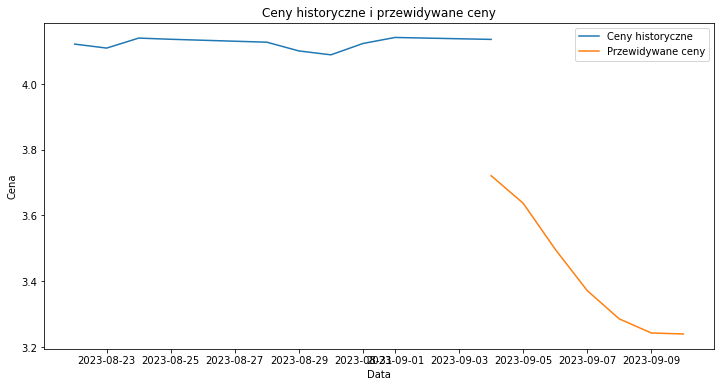

In [60]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Konwertowanie kolumny 'Date' na obiekt datetime
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values(by='Date', ascending=False)

# Wczytanie modelu
model = load_model('model.h5')

# Tworzenie sekwencji czasowych
time_steps = 10
X, y = create_sequences(df2[['Price', 'Open', 'High', 'Low']], df2['Price'], time_steps)

# Przewidywanie cen na kolejne 7 dni
predictions = []
current_sequence = X[-1]
for i in range(7):
    current_sequence = current_sequence.reshape(1, time_steps, 4)
    next_prediction = model.predict(current_sequence)
    last_date = df2['Date'].max()
    next_date = last_date + datetime.timedelta(days=1)
    predictions.append((next_date, next_prediction[0, 0]))
    new_prediction = np.array([[next_prediction[0, 0], 0, 0, 0]]).reshape(1, 1, 4)
    current_sequence = np.concatenate([current_sequence[:, 1:, :], new_prediction], axis=1)

# Odwrócenie skali i przygotowanie danych do wykresu
historical_data = df2.head(time_steps)
historical_data['Price'] = scaler.inverse_transform(historical_data['Price'].values.reshape(-1, 1))
historical_data = historical_data.set_index('Date')
predictions = scaler.inverse_transform(np.array(predictions)[:, 1].reshape(-1, 1))
date_range = pd.date_range(start=df2['Date'].max(), periods=7, freq='D')
predictions_with_dates = pd.DataFrame({'Date': date_range, 'Price': predictions.flatten()})
predictions_with_dates = predictions_with_dates.set_index('Date')

# Wyświetlenie danych na wykresie
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(historical_data['Price'], label='Ceny historyczne')
ax.plot(predictions_with_dates['Price'], label='Przewidywane ceny')
ax.set_xlabel('Data')
ax.set_ylabel('Cena')
ax.set_title('Ceny historyczne i przewidywane ceny')
ax.legend()
plt.show();
